In [9]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.utils import data

from tqdm.notebook import tqdm_notebook

import warnings
warnings.filterwarnings('ignore')

device = torch.device("mps" if torch.has_mps else "cpu")
print(device)
from itertools import product
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from aif360.algorithms.postprocessing import (CalibratedEqOddsPostprocessing,
                                              EqOddsPostprocessing,
                                              RejectOptionClassification)
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.metrics.utils import compute_boolean_conditioning_vector
random_state = 1

mps


In [10]:
# read in data and split
X = torch.load('inputs/bfw_resnet50_face_embeddings.pt').cpu()
y = torch.load('inputs/bfw_resnet50_labels.pt').cpu()
df = pd.read_csv('inputs/bfw_resnet50_df.csv')
gender = df['reference_gender']
df

,reference_identity,candidate_identity,reference_ethnicity,candidate_ethnicity,reference_gender,candidate_gender,labels
0,n004721,n004721,asian,asian,male,male,1.0
1,n004721,n004721,asian,asian,male,male,1.0
2,n004721,n004721,asian,asian,male,male,1.0
3,n004721,n004721,asian,asian,male,male,1.0
4,n004721,n004721,asian,asian,male,male,1.0
...,...,...,...,...,...,...,...
38395,n003412,n005685,white,white,male,male,0.0
38396,n008917,n008839,black,black,female,female,0.0
38397,n008452,n008150,asian,asian,male,male,0.0
38398,n004936,n002509,asian,asian,female,female,0.0


In [11]:
train_split, test_split = train_test_split(np.arange(len(X)),test_size=0.2, random_state=random_state)
train_split, val_split = train_test_split(train_split,test_size=0.25, random_state=random_state)
X_train = X[train_split]
X_val = X[val_split]
X_test = X[test_split]
y_train = y[train_split]
y_val = y[val_split]
y_test = y[test_split]

gender_train = gender[train_split].values
gender_train[gender_train=='male'] = 0
gender_train[gender_train=='female'] = 1
gender_train = gender_train.astype(int)

gender_val = gender[val_split].values
gender_val[gender_val=='male'] = 0
gender_val[gender_val=='female'] = 1
gender_val = gender_val.astype(int)

gender_test = gender[test_split].values
gender_test[gender_test=='male'] = 0
gender_test[gender_test=='female'] = 1
gender_test = gender_test.astype(int)

In [12]:
train_df = df.iloc[train_split]
val_df = df.iloc[val_split]
test_df = df.iloc[test_split]
test_df

,reference_identity,candidate_identity,reference_ethnicity,candidate_ethnicity,reference_gender,candidate_gender,labels
340,n005178,n005178,asian,asian,male,male,1.0
18908,n001229,n001229,white,white,female,female,1.0
37816,n008972,n003463,asian,asian,male,male,0.0
10524,n000138,n000138,asian,asian,female,female,1.0
7492,n003398,n003398,white,white,male,male,1.0
...,...,...,...,...,...,...,...
7045,n007184,n007184,indian,indian,male,male,1.0
10213,n004472,n004472,asian,asian,female,female,1.0
12000,n002274,n002274,black,black,female,female,1.0
36114,n000660,n008636,white,white,female,female,0.0


In [13]:
## train data
class TrainData(data.Dataset):
    
    def __init__(self, X_data, y_data,gender):
        self.X_data = X_data
        self.y_data = y_data
        self.gender = gender    
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index], self.gender[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = TrainData(torch.FloatTensor(X_train), 
                       torch.FloatTensor(y_train),
                       gender_train)
test_data = TrainData(torch.FloatTensor(X_test),torch.FloatTensor(y_test),gender_test)
val_data = TrainData(torch.FloatTensor(X_val), 
                       torch.FloatTensor(y_val),
                       gender_val)
class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__()
        # Number of input features is 4096
        self.layer_1 = nn.Linear(4096, 1024) 
        self.layer_2 = nn.Linear(1024, 512)
        self.layer_out = nn.Linear(512, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(1024)
        self.batchnorm2 = nn.BatchNorm1d(512)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

def confusion_mat(y_pred, y_test):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    acc = (tn + tp)/(tn+tp+fn+fp)
    return tn, fp, fn, tp, acc
    
def AOE(tn_1,fp_1,fn_1,tp_1,tn_0,fp_0,fn_0,tp_0):
    tpr_1 = tp_1/(tp_1+fn_1)
    tpr_0 = tp_0/(tp_0+fn_0)

    fpr_1 = fp_1/(fp_1+tn_1)
    fpr_0 = fp_0/(fp_0+tn_0)


    return (np.abs(fpr_1-fpr_0) + np.abs(tpr_1 - tpr_0))/2


In [14]:
model = torch.load('weights/bfw_resnet50_logistic_regression_face_matching.pt')
model.to(device)
model.to(device)
criterion = nn.BCEWithLogitsLoss()
BATCH_SIZE = 64
train_loader = data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(dataset=test_data, batch_size=BATCH_SIZE)
val_loader = data.DataLoader(dataset=val_data, batch_size=BATCH_SIZE)

In [36]:
val_labels = []
val_scores = []
val_genders = []
model.eval()
with torch.no_grad():
    for X_val, y_val, gender_val in val_loader:
        X_val, y_val = X_val.to(device), y_val.to(device)
        val_out = model(X_val)
        val_score = torch.sigmoid(val_out)
        val_labels.append(y_val)
        val_scores.append(val_score)
        val_genders.append(gender_val)
val_labels = torch.cat(val_labels)
val_scores = torch.cat(val_scores).reshape(-1)
val_genders = torch.cat(val_genders)


In [38]:
thresholds = np.arange(0,1.001,0.001)
tpr_list = []
tnr_list = []
fpr_list = []
fnr_list = []
acc_list = []
for thresh in tqdm_notebook(thresholds,total=len(thresholds)):
    pred = (val_scores>thresh)*1
    tn, fp, fn, tp, acc = confusion_mat(pred.cpu().numpy(), val_labels.cpu().numpy())
    tnr_list.append(tn/(tn+fp))
    tpr_list.append(tp/(tp+fn))
    fnr_list.append(fn/(fn+tp))
    fpr_list.append(fp/(fp+tn))
    acc_list.append(acc)

  0%|          | 0/1001 [00:00<?, ?it/s]

In [39]:
def solve(f,x):
    s = np.sign(f)
    z = np.where(s == 0)[0]
    if z:
        return z
    else:
        s = s[0:-1] + s[1:]
        z = np.where(s == 0)[0]
        return z

def interp(f,x,z):
    m = (f[z+1] - f[z]) / (x[z+1] - x[z])
    return x[z] - f[z]/m
f = np.array(fnr_list)-np.array(fpr_list)
z = solve(f,thresholds)
ans = interp(f,thresholds,z)
ans

array([0.70590139])

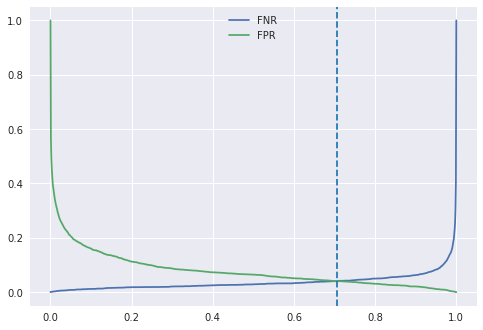

In [40]:
with plt.style.context('seaborn'):    
    plt.plot(thresholds,fnr_list,label='FNR')
    plt.plot(thresholds,fpr_list,label='FPR')
    # plt.plot(thresholds,np.array(fnr_list)-np.array(fpr_list))
    plt.axvline(x=ans,linestyle ='--')
    plt.legend()
plt.show()

In [41]:
print(thresholds[np.abs(thresholds-ans).argmin()])
print(thresholds[acc_list == max(acc_list)])

0.706
[0.817 0.818 0.819 0.82  0.821 0.828]


In [43]:
eer_thresh = 0.706
acc_thresh = 0.817
eer_pred = (val_scores>eer_thresh)*1
acc_pred = (val_scores>acc_thresh)*1
df_bias = val_df.drop(['reference_identity','candidate_identity','reference_ethnicity','candidate_ethnicity','candidate_gender'],axis=1)
df_bias['eer_pred'] = eer_pred.cpu().numpy()
df_bias['acc_pred'] = acc_pred.cpu().numpy()
df_bias_female = df_bias[df_bias['reference_gender']=='female']
df_bias_male = df_bias[df_bias['reference_gender']=='male']

female_eer_tn, female_eer_fp, female_eer_fn, female_eer_tp, female_eer_acc = confusion_mat(df_bias_female['eer_pred'], df_bias_female['labels'])
male_eer_tn, male_eer_fp, male_eer_fn, male_eer_tp, male_eer_acc = confusion_mat(df_bias_male['eer_pred'], df_bias_male['labels'])

female_acc_tn, female_acc_fp, female_acc_fn, female_acc_tp, female_acc_acc = confusion_mat(df_bias_female['acc_pred'], df_bias_female['labels'])
male_acc_tn, male_acc_fp, male_acc_fn, male_acc_tp, male_acc_acc = confusion_mat(df_bias_male['acc_pred'], df_bias_male['labels'])



In [44]:
female_eer_tnr = female_eer_tn/(female_eer_tn+female_eer_fp)
female_eer_tpr = female_eer_tp/(female_eer_tp+female_eer_fn)
female_eer_fnr = female_eer_fn/(female_eer_fn+female_eer_tp)
female_eer_fpr = female_eer_fp/(female_eer_tn+female_eer_fp)

male_eer_tnr = male_eer_tn/(male_eer_tn+male_eer_fp)
male_eer_tpr = male_eer_tp/(male_eer_tp+male_eer_fn)
male_eer_fnr = male_eer_fn/(male_eer_fn+male_eer_tp)
male_eer_fpr = male_eer_fp/(male_eer_tn+male_eer_fp)

print(female_eer_fnr/male_eer_fnr)
print(female_eer_fpr/male_eer_fpr)
print(male_eer_tnr/female_eer_tnr)
print(male_eer_tpr/female_eer_tpr)
print((1-female_eer_acc)/(1-male_eer_acc))

1.4365671641791047
0.9315944388777554
0.9969739959791796
1.015492742551566
1.153035052721574


In [45]:
print('female fnr:',female_eer_fnr,'male fnr:',male_eer_fnr)
print('female fpr:',female_eer_fpr,'male fpr:',male_eer_fpr)
print('male tnr:',male_eer_tnr,'male tnr:',female_eer_tnr)
print('male tpr:',male_eer_tpr,'male tpr:',female_eer_tpr)
print('male mis class:',(1-female_eer_acc),'male mis class:',(1-male_eer_acc))

female fnr: 0.048507462686567165 male fnr: 0.033766233766233764
female fpr: 0.039579158316633264 male fpr: 0.04248539564524695
female tnr: 0.9575146043547531 male tnr: 0.9604208416833667
female tpr: 0.9662337662337662 male tpr: 0.9514925373134329
female mis class: 0.04390495867768596 male mis class: 0.03807773109243695


In [46]:
test_labels = []
test_scores = []
test_genders = []
eer_thresh = 0.706
model.eval()
with torch.no_grad():
    for X_test, y_test, gender_test in test_loader:
        X_test, y_test = X_test.to(device), y_test.to(device)
        test_out = model(X_test)
        test_score = torch.sigmoid(test_out)
        test_labels.append(y_test)
        test_scores.append(test_score)
        test_genders.append(gender_test)
test_labels = torch.cat(test_labels)
test_scores = torch.cat(test_scores).reshape(-1)
test_predictions = (test_scores>eer_thresh)*1
test_genders = torch.cat(test_genders)

In [47]:
test_bias_df = pd.DataFrame(columns=['label','prediction','protected'])
test_bias_df['label']=test_labels.cpu().numpy()
test_bias_df['prediction']=test_predictions.cpu().numpy()
test_bias_df['protected']=test_genders.cpu().numpy()
test_bias_df

,label,prediction,protected
0,1.0,1,0
1,1.0,1,1
2,0.0,0,0
3,1.0,1,1
4,1.0,1,0
...,...,...,...
7675,1.0,1,0
7676,1.0,1,1
7677,1.0,1,1
7678,0.0,0,1


In [48]:
unpriveleged_df = test_bias_df[test_bias_df['protected']==1]
unpriveleged_df

,label,prediction,protected
1,1.0,1,1
3,1.0,1,1
5,1.0,1,1
6,1.0,1,1
7,0.0,1,1
...,...,...,...
7672,1.0,1,1
7676,1.0,1,1
7677,1.0,1,1
7678,0.0,0,1


In [49]:
priveleged_df = test_bias_df[test_bias_df['protected']==0]
priveleged_df

,label,prediction,protected
0,1.0,1,0
2,0.0,0,0
4,1.0,1,0
8,0.0,0,0
9,0.0,0,0
...,...,...,...
7670,0.0,0,0
7671,0.0,0,0
7673,0.0,0,0
7674,0.0,0,0


In [50]:
unpriveleged_tn, unpriveleged_fp, unpriveleged_fn, unpriveleged_tp, unpriveleged_acc = confusion_mat(unpriveleged_df['prediction'], unpriveleged_df['label'])
priveleged_tn, priveleged_fp, priveleged_fn, priveleged_tp, priveleged_acc = confusion_mat(priveleged_df['prediction'], priveleged_df['label'])
unpriveleged_fnr = unpriveleged_fn/(unpriveleged_fn+unpriveleged_tp)
unpriveleged_fpr = unpriveleged_fp/(unpriveleged_fp+unpriveleged_tn)
priveleged_fnr = priveleged_fn/(priveleged_fn+priveleged_tp)
priveleged_fpr = priveleged_fp/(priveleged_fp+priveleged_tn)

print('Overall Accuracy:',round(torch.sum(test_predictions == test_labels).item()/test_labels.size()[0],3))
print('Missclassificaition Rate Ratio:',round((1-unpriveleged_acc)/(1- priveleged_acc),3))
print('FNR Ratio:',round(unpriveleged_fnr/priveleged_fnr,3),'FPR Ratio:',round(unpriveleged_fpr/priveleged_fpr,3))
print('AOE:',round(AOE(unpriveleged_tn,unpriveleged_fp,unpriveleged_fn,unpriveleged_tp,priveleged_tn,priveleged_fp,priveleged_fn,priveleged_tp),3))

Overall Accuracy: 0.96
Missclassificaition Rate Ratio: 1.072
FNR Ratio: 0.891 FPR Ratio: 1.234
AOE: 0.007


In [51]:
### AIF implementations
def val(model,dataloader):
    y_true, y_pred, y_prot = [],[],[]
    model.eval()
    with torch.no_grad():
        for X_val, y_val,prot in dataloader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            y_pred.append(torch.sigmoid(model(X_val)[:, 0]))
            y_true.append(y_val)
            y_prot.append(prot)
    y_true, y_pred, y_prot = torch.cat(y_true), torch.cat(y_pred), torch.cat(y_prot)
    return y_true, y_pred, y_prot

def to_dataframe(y_true, y_pred, y_prot):
        y_true, y_pred, y_prot = y_true.float().cpu().numpy(), y_pred.float().cpu().numpy(), y_prot.float().cpu().numpy()
        df = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred, 'y_prot': y_prot})
        dataset = StandardDataset(df, 'y_true', [1.], ['y_prot'], [[1.]])
        dataset.scores = y_pred.reshape(-1, 1)
        return dataset

In [52]:
y_true, y_pred, y_prot = val(model,test_loader)
aif_data = to_dataframe(y_true, y_pred, y_prot)

In [59]:
cost_constraint = 'weighted'
privileged_groups=[{'y_prot': 0.}],
unprivileged_groups=[{'y_prot': 1.}]
cpp = CalibratedEqOddsPostprocessing(privileged_groups=[{'y_prot': 0.}],
                                             unprivileged_groups=[{'y_prot': 1.}],
                                             cost_constraint=cost_constraint,seed=random_state)
cpp=cpp.fit(aif_data,aif_data)
cpp_pred = cpp.predict(aif_data).labels.reshape(-1)
cpp_label = aif_data.labels.reshape(-1)
cpp_prot = aif_data.protected_attributes.reshape(-1)

unpriv_ids = (cpp_prot==1)
unpriv_pred = cpp_pred[unpriv_ids]
unpriv_label = cpp_label[unpriv_ids]

priv_ids = (cpp_prot==0)
priv_pred = cpp_pred[priv_ids]
priv_label = cpp_label[priv_ids]

unpriv_tn, unpriv_fp, unpriv_fn, unpriv_tp, unpriv_acc = confusion_mat(unpriv_pred, unpriv_label)
unpriv_fpr = unpriv_fp/(unpriv_fp+unpriv_tn)
unpriv_fnr = unpriv_fn/(unpriv_fn+unpriv_tp)

priv_tn, priv_fp, priv_fn, priv_tp, priv_acc = confusion_mat(priv_pred, priv_label)
priv_fpr = priv_fp/(priv_fp+priv_tn)
priv_fnr = priv_fn/(priv_fn+priv_tp)

print('Missclassificaition Rate Ratio:',round((1-unpriv_acc)/(1- priv_acc),3))
print('FPR Ratio:',round(unpriv_fpr/priv_fpr,3))
print('FNR Ratio:',round(unpriv_fnr/priv_fnr,3))
print('Overall Accuracy:',round(np.sum(cpp_pred == cpp_label)/len(cpp_label),3))
print('AOE:',round(AOE(unpriv_tn, unpriv_fp, unpriv_fn, unpriv_tp,priv_tn, priv_fp, priv_fn, priv_tp),3))

Missclassificaition Rate Ratio: 0.988
FPR Ratio: 1.09
FNR Ratio: 0.8
Overall Accuracy: 0.953
AOE: 0.006


In [60]:
eo = EqOddsPostprocessing(privileged_groups=[{'y_prot': 0.}],
                                  unprivileged_groups=[{'y_prot': 1.}],seed=random_state)

eo=eo.fit(aif_data,aif_data)

eo_pred = eo.predict(aif_data).labels.reshape(-1)
eo_label = aif_data.labels.reshape(-1)
eo_prot = aif_data.protected_attributes.reshape(-1)

eo_unpriv_ids = (eo_prot==1)
eo_unpriv_pred = eo_pred[eo_unpriv_ids]
eo_unpriv_label = eo_label[eo_unpriv_ids]

eo_priv_ids = (eo_prot==0)
eo_priv_pred = eo_pred[eo_priv_ids]
eo_priv_label = eo_label[eo_priv_ids]

eo_unpriv_tn, eo_unpriv_fp, eo_unpriv_fn, eo_unpriv_tp, eo_unpriv_acc = confusion_mat(eo_unpriv_pred, eo_unpriv_label)
eo_unpriv_fpr = eo_unpriv_fp/(eo_unpriv_fp+eo_unpriv_tn)
eo_unpriv_fnr = eo_unpriv_fn/(eo_unpriv_fn+eo_unpriv_tp)

eo_priv_tn, eo_priv_fp, eo_priv_fn, eo_priv_tp, eo_priv_acc = confusion_mat(eo_priv_pred, eo_priv_label)
eo_priv_fpr = eo_priv_fp/(eo_priv_fp+eo_priv_tn)
eo_priv_fnr = eo_priv_fn/(eo_priv_fn+eo_priv_tp)

print('Missclassificaition Rate Ratio:',round((1-eo_unpriv_acc)/(1- eo_priv_acc),3))
print('FPR Ratio:',eo_unpriv_fpr/eo_priv_fpr)
print('FNR Ratio:',eo_unpriv_fnr/eo_priv_fnr)
print(np.sum(eo_pred == eo_label)/len(eo_pred))
print('AOE:',round(AOE(eo_unpriv_tn, eo_unpriv_fp, eo_unpriv_fn, eo_unpriv_tp,eo_priv_tn, eo_priv_fp, eo_priv_fn, eo_priv_tp),3))


Missclassificaition Rate Ratio: nan
FPR Ratio: nan
FNR Ratio: nan
1.0
AOE: 0.0


In [61]:
ROC = RejectOptionClassification(unprivileged_groups=[{'y_prot': 1.}],
                                         privileged_groups=[{'y_prot': 0.}],
                                         low_class_thresh=0.01, high_class_thresh=0.99,
                                         num_class_thresh=100, num_ROC_margin=100,
                                         metric_name="Average odds difference",
                                         metric_ub=0.01, metric_lb=-0.01)

ROC = ROC.fit(aif_data, aif_data)

ROC_pred = ROC.predict(aif_data).labels.reshape(-1)
ROC_label = aif_data.labels.reshape(-1)
ROC_prot = aif_data.protected_attributes.reshape(-1)

ROC_unpriv_ids = (ROC_prot==1)
ROC_unpriv_pred = ROC_pred[ROC_unpriv_ids]
ROC_unpriv_label = ROC_label[ROC_unpriv_ids]

ROC_priv_ids = (ROC_prot==0)
ROC_priv_pred = ROC_pred[ROC_priv_ids]
ROC_priv_label = ROC_label[ROC_priv_ids]

ROC_unpriv_tn, ROC_unpriv_fp, ROC_unpriv_fn, ROC_unpriv_tp, ROC_unpriv_acc = confusion_mat(ROC_unpriv_pred, ROC_unpriv_label)
ROC_unpriv_fpr = ROC_unpriv_fp/(ROC_unpriv_fp+ROC_unpriv_tn)
ROC_unpriv_fnr = ROC_unpriv_fn/(ROC_unpriv_fn+ROC_unpriv_tp)

ROC_priv_tn, ROC_priv_fp, ROC_priv_fn, ROC_priv_tp, ROC_priv_acc = confusion_mat(ROC_priv_pred, ROC_priv_label)
ROC_priv_fpr = ROC_priv_fp/(ROC_priv_fp+ROC_priv_tn)
ROC_priv_fnr = ROC_priv_fn/(ROC_priv_fn+ROC_priv_tp)

print('Missclassificaition Rate Ratio:',round((1-ROC_unpriv_acc)/(1- ROC_priv_acc),3))
print('FPR Ratio:',round(ROC_unpriv_fpr/ROC_priv_fpr,3))
print('FNR Ratio:',round(ROC_unpriv_fnr/ROC_priv_fnr,3))
print(np.sum(ROC_pred == ROC_label)/len(ROC_pred))
print('AOE:',round(AOE(ROC_unpriv_tn, ROC_unpriv_fp, ROC_unpriv_fn, ROC_unpriv_tp,ROC_priv_tn, ROC_priv_fp, ROC_priv_fn, ROC_priv_tp),3))


Missclassificaition Rate Ratio: 1.039
FPR Ratio: 1.23
FNR Ratio: 0.877
0.961328125
AOE: 0.007
